In [ ]:
# Importing the required libraries
import numpy as np
import cv2
from cv2 import dct, idct
from PIL import Image
import math 
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from collections import Counter, defaultdict
import heapq
import os
import pandas as pd

In [ ]:
# Function to read the image and plot it
def view_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()

In [80]:
# Define a helper class to build the Huffman tree
class HuffmanNode:
    def __init__(self, value, freq):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman tree
def build_huffman_tree(frequency):
    heap = [HuffmanNode(value, freq) for value, freq in frequency.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        
        heapq.heappush(heap, merged)
    
    return heap[0]  # Root of the Huffman tree

# Function to generate Huffman codes
def generate_huffman_codes(root):
    huffman_codes = {}
    
    def generate_codes(node, current_code=""):
        if node is None:
            return
        if node.value is not None:
            huffman_codes[node.value] = current_code
            return
        generate_codes(node.left, current_code + "0")
        generate_codes(node.right, current_code + "1")
    
    generate_codes(root)
    return huffman_codes

In [ ]:
# Functions to convert integers to binary strings of required length
def bin4(x):
    if x >= 0:
        return format(x, '04b')
    else:
        return format((1 << 4) + x, '04b')


def bin8(x):   
    if x >= 0:
        return format(x, '08b')
    else:
        return format((1 << 8) + x, '08b')
    
def bin16(x):
    if x >= 0:
        return format(x, '016b')
    else:
        return format((1 << 16) + x, '016b')
    
def bin12(x):
    if x >= 0:
        return format(x, '012b')
    else:
        return format((1 << 12) + x, '012b')

In [ ]:
# Function to pair run-length and amplitude values
def pair_numbers(string):
    # Split the string by spaces and convert each part to an integer
    numbers = list(map(int, string.split()))
    
    # Use list comprehension to group numbers into pairs of two
    pairs = [(numbers[i], numbers[i + 1]) for i in range(0, len(numbers), 2)]
    
    return pairs

In [ ]:
# Encoding function which converts RLE to Huffman encoding
class Encoder:
    def encode(self, rle_img):
        # Extract values for Huffman encoding
        values = [val for count, val in rle_img]
        
        # Build Huffman Tree
        frequency = Counter(values)
        huffman_tree = build_huffman_tree(frequency)
        huffman_codes = generate_huffman_codes(huffman_tree)

        # Encode RLE data with Huffman codes
        encoded_huffman = ""
        non_encoded = ""    # Unused for this implementation

        for run, val in rle_img:
            # Convert run to binary
            while run>15:   # If run is greater than 15, encode 16 zeros
                encoded_huffman += '1111' + bin8(len(huffman_codes[0])) + huffman_codes[0] 
                run -= 16
            binary_run = bin4(run)
            huffman_len = bin8(len(huffman_codes[val]))
            encoded_huffman += binary_run + huffman_len + huffman_codes[val]
        
        return encoded_huffman, huffman_codes, non_encoded

In [ ]:
class Decoder:    

    @staticmethod
    def decode_huffman(binary_data):
        # Convert data to 0s and 1s
        binary_data = ''.join(format(byte, '08b') for byte in binary_data)

        # Read the quality factor
        qf = int(binary_data[:8], 2)
        binary_data = binary_data[8:]

        # Read the length of huffman codes data 
        length_huffman = int(binary_data[:32], 2) * 8
        binary_data = binary_data[32:]
        skip_head1 = int(binary_data[:8], 2)
        binary_data = binary_data[8:]
        binary_data = binary_data[skip_head1:]

        # Read the huffman codes
        huffman_codes = {}
        while length_huffman - skip_head1 > 0:
            key = int(binary_data[:12], 2)
            if key > 2047:
                key = key - 4096
            # print('key', key)
            binary_data = binary_data[12:]
            length = int(binary_data[:8], 2)
            # print('length', length)
            binary_data = binary_data[8:]
            huffman_codes[key] = binary_data[:length]
            # print('huffman', huffman_codes[key])
            binary_data = binary_data[length:]
            length_huffman -= (20 + length) 

        # Read the huffman encoded data
        skip_head2 = int(binary_data[:8], 2)
        binary_data = binary_data[8:]
        binary_data = binary_data[skip_head2:]
        decoded = ""
        code = ""

        # huffman encoded data is in the form (run_length (4 bits), length of huffman (4 bits) , huffman code)
        # run_length is the number of zeros before the huffman code

        i = 0
        while i < len(binary_data):
            run = int(binary_data[i:i+4], 2)
            length = int(binary_data[i+4:i+12], 2)
            code = binary_data[i+12:i+12+length]
            if len(code) > 0:
                value = [key for key, value in huffman_codes.items() if value == code][0]   # Get the value corresponding to the huffman code
            else:
                value = 0
            decoded += str(run) + ' ' + str(value) + ' '    # Add the run length and value to the decoded data
            i += 12 + length

        return qf, decoded, huffman_codes
    
    @staticmethod
    def decode_from_rle(decoded, qf):
        quantizer = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
        quantizer = quantizer * (50/qf)

        pairs = pair_numbers(decoded)

        # Now we have the run-length encoded data in the form (run_length, value)
        # each block is separated by (0, 0)
        # Each block is 8x8
        # First get a flattened version of all the blocks
        blocks = []
        block = []
        prev_dc = 0     
        total_entries = 0
        for run, value in pairs:
            if run == 0 and value == 0:
                number_zeros = 64 - total_entries
                block += [0] * number_zeros
                block[0] += prev_dc
                prev_dc = block[0]
                blocks.append(block)
                block = []
                total_entries = 0
            else:
                block += [0] * run + [value]
                total_entries += run + 1
        
        return blocks, quantizer

    # Reverse zig zag order
    # Input is list of length 64, output is 8x8 matrix
    @staticmethod
    def zigzag_unflatten(flat_list, rows, cols):
        # Initialize an empty matrix
        matrix = np.zeros((rows, cols), dtype=int)
        index = 0

        for s in range(rows + cols - 1):
            if s % 2 == 0:
                # Go upward-right
                r = min(s, rows - 1)
                c = s - r
                while r >= 0 and c < cols:
                    matrix[r, c] = flat_list[index]
                    index += 1
                    r -= 1
                    c += 1
            else:
                # Go downward-left
                c = min(s, cols - 1)
                r = s - c
                while c >= 0 and r < rows:
                    matrix[r, c] = flat_list[index]
                    index += 1
                    r += 1
                    c -= 1

        return matrix
    
    # Apply rev zig zag and dequantize
    @staticmethod
    def dequantize(blocks, quantizer):
        decoded_blocks = []
        for block in blocks:
            block = Decoder.zigzag_unflatten(block, 8, 8)
            decoded_blocks.append(block * quantizer)

        # Apply inverse DCT
        decoded_image = np.zeros((512, 512))
        for i in range(0, 512, 8):
            for j in range(0, 512, 8):
                decoded_image[i:i+8, j:j+8] = idct(np.float32(decoded_blocks[i//8*64 + j//8])) + 128
                decoded_image[i:i+8, j:j+8] = np.clip(decoded_image[i:i+8, j:j+8], 0, 255)
        decoded_image = np.uint8(decoded_image)
        return decoded_image

In [ ]:
class JPEG(Encoder, Decoder):
    def __init__(self, filename, folder, quality=50):
        self.image = plt.imread(folder + filename)
        self.quality = quality
        self.filename = filename
        self.folder = folder
        quantizer = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                              [12, 12, 14, 19, 26, 58, 60, 55],
                              [14, 13, 16, 24, 40, 57, 69, 56],
                              [14, 17, 22, 29, 51, 87, 80, 62],
                              [18, 22, 37, 56, 68, 109, 103, 77],
                              [24, 35, 55, 64, 81, 104, 113, 92],
                              [49, 64, 78, 87, 103, 121, 120, 101],
                              [72, 92, 95, 98, 112, 100, 103, 99]])     # Standard quantization matrix
        
        self.quantizer = quantizer * (50/quality)       # Adjust the quantization matrix according to quality factor

    def dct2D(self):
        self.dct_matrix = np.zeros(self.image.shape)
        for i in range(0, self.image.shape[0], 8):
            for j in range(0, self.image.shape[1], 8):
                self.dct_matrix[i:i+8, j:j+8] = dct(np.float32(self.image[i:i+8, j:j+8]) - 128)     # Subtract 128 from the block and apply DCT

    def quantize(self):
        self.quantized_matrix = np.zeros(self.image.shape)
        for i in range(0, self.image.shape[0], 8):
            for j in range(0, self.image.shape[1], 8):
                self.quantized_matrix[i:i+8, j:j+8] = np.round(self.dct_matrix[i:i+8, j:j+8] / self.quantizer)  # Divide the DCT matrix by quantization matrix and round off
    
    def zigzag_flatten(self, matrix):   # Flatten the matrix according to zigzag order
        rows, cols = matrix.shape
        result = []
        
        for s in range(rows + cols - 1):
            if s % 2 == 0:
                # Go upward-right
                r = min(s, rows - 1)
                c = s - r
                while r >= 0 and c < cols:
                    result.append(matrix[r, c])
                    r -= 1
                    c += 1
            else:
                # Go downward-left
                c = min(s, cols - 1)
                r = s - c
                while c >= 0 and r < rows:
                    result.append(matrix[r, c])
                    r += 1
                    c -= 1           
        return result
    
    def rle_encode(self):
        rle = []
        prev_dc = 0    # Previous DC value  
        for i in range(0, self.image.shape[0], 8):
            for j in range(0, self.image.shape[1], 8):
                block = self.quantized_matrix[i:i+8, j:j+8]
                block_flatten = self.zigzag_flatten(block)      # Flatten the block in zigzag order
                block_flatten[0] -= prev_dc   # Subtract the previous DC value from the current DC value
                prev_dc = block_flatten[0] + prev_dc    # Update the previous DC value
                block_flatten = np.trim_zeros(block_flatten, 'b')   # Remove trailing zeros

                # RLE
                count = 0
                for value in block_flatten:
                    if value == 0:
                        count += 1  # Count the number of zeros
                    else:
                        rle.append((count, value))  # Add the count and value to the RLE
                        count = 0

                rle.append((0, 0))  # End of block

        return rle

    def encode(self):
        encoder = Encoder()
        rle_img = self.rle_encode()
        self.encoded, self.huffman_codes, self.non_encoded = encoder.encode(rle_img)    # non_encoded is not used in this implementation

    def save(self):
        # Save the huffman codes and encoded data to a binary file
        self.binary_huffmancodes = ""
        for key, value in self.huffman_codes.items():   # Convert the huffman codes to binary
            self.binary_huffmancodes += bin12(int(key)) + bin8(len(value)) + value

        self.binary_qf = bin8(self.quality)
        self.binary_qf = int(self.binary_qf, 2).to_bytes((len(self.binary_qf) + 7) // 8, byteorder='big')   # Convert quality factor to bytes

        self.binary_huffman_data = int(self.binary_huffmancodes, 2).to_bytes((len(self.binary_huffmancodes) + 7) // 8, byteorder='big')  # Convert huffman codes to bytes
        self.len_huffman_data = len(self.binary_huffman_data).to_bytes(4, byteorder='big')  # Convert length of huffman codes to bytes
        self.skip_head1 = (len(self.binary_huffman_data*8) - len(self.binary_huffmancodes))% 8      # Calculate the number of bits to skip
        self.binary_sh1 = int(bin8(self.skip_head1),2).to_bytes(1, byteorder='big')   # Convert the number of bits to skip to 1 byte

        self.binary_data = int(self.encoded, 2).to_bytes((len(self.encoded) + 7) // 8, byteorder='big')  # Convert the encoded data to bytes
        self.skip_head2 = (len(self.binary_data)*8 - len(self.encoded)) % 8  # Calculate the number of bits to skip
        self.binary_sh2 = int(bin8(self.skip_head2),2).to_bytes(1, byteorder='big')  # Convert the number of bits to skip to 1 byte

        with open("compressed_" + self.filename[:-4] + ".bin", "wb") as file:   # Save the compressed data to a binary file
            file.write(self.binary_qf)
            file.write(self.len_huffman_data)
            file.write(self.binary_sh1)
            file.write(self.binary_huffman_data)
            file.write(self.binary_sh2)
            file.write(self.binary_data)

    def decode(self):

        with open("compressed_" + self.filename[:-4] + ".bin", "rb") as file:   # Read the compressed data from the binary file
            self.extracted_data = file.read()

        qf, decoded, huffman_codes = Decoder.decode_huffman(self.extracted_data)    # Decode the huffman encoded data
        blocks, quantizer = Decoder.decode_from_rle(decoded, qf)    # Decode the RLE data
        self.compressed_image = Decoder.dequantize(blocks, quantizer)   # Dequantize the blocks and apply inverse DCT
        # print('Decompressed Image:', self.decompressed_image)

    def compress(self):
        # Apply the JPEG compression algorithm
        self.dct2D()
        self.quantize()
        self.encode()
        self.save()
        self.decode()

    def evaluate(self):
        self.ssim = ssim(self.image, self.compressed_image, data_range=self.image.max() - self.image.min()) # Calculate SSIM
        self.psnr = psnr(self.image, self.compressed_image)  # Calculate PSNR
        self.mse = mse(self.image, self.compressed_image)   # Calculate MSE
        self.rmse = math.sqrt(self.mse) # Calculate RMSE

        self.compressed_size = os.path.getsize("compressed_" + self.filename[:-4] + ".bin") # Calculate the size of the compressed file
        self.bpp = self.compressed_size * 8 / (self.image.shape[0] * self.image.shape[1])   # Calculate bits per pixel
        self.original_size = os.path.getsize(self.folder + self.filename)   # Calculate the size of the original file
        self.compression_ratio = self.original_size / self.compressed_size  # Calculate the compression ratio

In [ ]:
def save_image_at_various_qualities(input_image_path, output_folder):
    # Load the image
    image = Image.open(input_image_path)
    image_np = np.array(image)  # Convert once to NumPy array for metric comparisons

    # Define quality levels (ensure integer values)
    quality_levels = np.linspace(1, 100, 100, dtype=int)

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    MSE = []
    RMSE = []
    PSNR = []
    SSIM = []
    CR = []
    BPP = []

    # Save image at each quality level
    for quality in quality_levels:
        output_path = os.path.join(output_folder, f"image_quality_{quality}.jpg")
        image.save(output_path, format='JPEG', quality=int(quality))  # Ensure quality is integer

        # Compute metrics
        image_compressed = Image.open(output_path)
        image_compressed_np = np.array(image_compressed)

        # Calculate metrics and append results
        mse_value = mse(image_np, image_compressed_np)
        MSE.append(mse_value)
        RMSE.append(np.sqrt(mse_value))
        PSNR.append(psnr(image_np, image_compressed_np))
        SSIM.append(ssim(image_np, image_compressed_np, multichannel=True))

        print(f"Image size: {os.path.getsize(output_path)} bytes")
        print(f"Original size: {os.path.getsize(input_image_path)} bytes")
        cr = os.path.getsize(input_image_path) / os.path.getsize(output_path)
        print(f"Compression ratio: {cr}\n")
        CR.append(cr)
        BPP.append(os.path.getsize(output_path) * 8 / (image_np.shape[0] * image_np.shape[1]))

    # Create DataFrame and save metrics to CSV
    df = pd.DataFrame({
        "Quality": quality_levels,
        "MSE": MSE,
        "RMSE": RMSE,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "Compression Ratio": CR,
        "Bits Per Pixel": BPP
    })

    df.to_csv(os.path.join(output_folder, "metrics.csv"), index=False)


In [87]:
def save_image_at_various_qualities_cv2(input_image_path, output_folder):
    # Load the grayscale image using OpenCV
    image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at {input_image_path} could not be loaded.")

    # Convert image to NumPy array
    image_np = np.array(image)  # Original image as NumPy array for metrics

    # Define quality levels (ensure integer values)
    quality_levels = np.linspace(1, 100, 100, dtype=int)

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    MSE = []
    RMSE = []
    PSNR = []
    SSIM = []
    CR = []
    BPP = []

    # Save image at each quality level
    for quality in quality_levels:
        output_path = os.path.join(output_folder, f"image_quality_{quality}.jpg")

        # Save the image with specified quality using OpenCV
        compression_params = [cv2.IMWRITE_JPEG_QUALITY, quality]
        success = cv2.imwrite(output_path, image, compression_params)
        if not success:
            print(f"Failed to save image at quality level {quality}")
            continue

        # Load the compressed image for metrics calculation
        image_compressed = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
        image_compressed_np = np.array(image_compressed)

        # Calculate metrics and append results
        mse_value = mse(image_np, image_compressed_np)
        MSE.append(mse_value)
        RMSE.append(np.sqrt(mse_value))
        PSNR.append(psnr(image_np, image_compressed_np))
        SSIM.append(ssim(image_np, image_compressed_np, multichannel=False))  # No multichannel for grayscale
        
        original_size = os.path.getsize(input_image_path)
        compressed_size = os.path.getsize(output_path)
        cr = original_size / compressed_size
        CR.append(cr)
        BPP.append(compressed_size * 8 / (image_np.shape[0] * image_np.shape[1]))

        print(f"Saved {output_path} at quality level {quality}")
        print(f"Original size: {original_size} bytes, Compressed size: {compressed_size} bytes")
        print(f"Compression Ratio: {cr}\n")

    # Create DataFrame and save metrics to CSV
    df = pd.DataFrame({
        "Quality": quality_levels,
        "MSE": MSE,
        "RMSE": RMSE,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "Compression Ratio": CR,
        "Bits Per Pixel": BPP
    })

    df.to_csv(os.path.join(output_folder, "metrics.csv"), index=False)


In [88]:
filename = 'C0489.bmp'
folder = 'caltech_greyscale/'

Q = np.linspace(1, 100, 100, dtype=int)

SSIM = []
PSNR = []
MSE = []
RMSE = []
CR = []
BPP = []

for q in Q:
    jpeg = JPEG(filename, folder, q)
    jpeg.compress()
    jpeg.evaluate()
    SSIM.append(jpeg.ssim)
    PSNR.append(jpeg.psnr)
    MSE.append(jpeg.mse)
    RMSE.append(jpeg.rmse)
    CR.append(jpeg.compression_ratio)
    BPP.append(jpeg.bpp)

In [89]:
input_image_path = 'caltech_greyscale/C0489.bmp'
output_folder = 'output_PIL_greyscale/'

save_image_at_various_qualities(input_image_path, output_folder)

Image size: 5141 bytes
Original size: 263222 bytes
Compression ratio: 51.2005446411204

Image size: 5150 bytes
Original size: 263222 bytes
Compression ratio: 51.11106796116505

Image size: 5612 bytes
Original size: 263222 bytes
Compression ratio: 46.90342124019957

Image size: 6562 bytes
Original size: 263222 bytes
Compression ratio: 40.11307528192624

Image size: 7526 bytes
Original size: 263222 bytes
Compression ratio: 34.97501993090619

Image size: 8514 bytes
Original size: 263222 bytes
Compression ratio: 30.916373032652103

Image size: 9388 bytes
Original size: 263222 bytes
Compression ratio: 28.038133787814232

Image size: 10245 bytes
Original size: 263222 bytes
Compression ratio: 25.692728160078087

Image size: 11066 bytes
Original size: 263222 bytes
Compression ratio: 23.786553406831736

Image size: 11861 bytes
Original size: 263222 bytes
Compression ratio: 22.192226625073772

Image size: 12632 bytes
Original size: 263222 bytes
Compression ratio: 20.837713742875238

Image size: 

In [90]:
input_image_path = 'caltech_greyscale/C0489.bmp'
output_folder = 'output_cv2_greyscale/'

save_image_at_various_qualities_cv2(input_image_path, output_folder)

Saved output_cv2_greyscale/image_quality_1.jpg at quality level 1
Original size: 263222 bytes, Compressed size: 5141 bytes
Compression Ratio: 51.2005446411204

Saved output_cv2_greyscale/image_quality_2.jpg at quality level 2
Original size: 263222 bytes, Compressed size: 5150 bytes
Compression Ratio: 51.11106796116505

Saved output_cv2_greyscale/image_quality_3.jpg at quality level 3
Original size: 263222 bytes, Compressed size: 5612 bytes
Compression Ratio: 46.90342124019957

Saved output_cv2_greyscale/image_quality_4.jpg at quality level 4
Original size: 263222 bytes, Compressed size: 6562 bytes
Compression Ratio: 40.11307528192624

Saved output_cv2_greyscale/image_quality_5.jpg at quality level 5
Original size: 263222 bytes, Compressed size: 7526 bytes
Compression Ratio: 34.97501993090619

Saved output_cv2_greyscale/image_quality_6.jpg at quality level 6
Original size: 263222 bytes, Compressed size: 8514 bytes
Compression Ratio: 30.916373032652103

Saved output_cv2_greyscale/image_q

In [91]:
df_matlab = pd.read_csv('compression_results.txt', sep='\t')
df_PIL = pd.read_csv('output_PIL_greyscale/metrics.csv')
df_cv2 = pd.read_csv('output_cv2_greyscale/metrics.csv')

print(df_matlab.columns)
print(df_PIL.columns)
print(df_cv2.columns)

Index(['Quality', 'SSIM', 'MSE', 'RMSE', 'PSNR', 'CompressionRatio', 'BPP'], dtype='object')
Index(['Quality', 'MSE', 'RMSE', 'PSNR', 'SSIM', 'Compression Ratio',
       'Bits Per Pixel'],
      dtype='object')
Index(['Quality', 'MSE', 'RMSE', 'PSNR', 'SSIM', 'Compression Ratio',
       'Bits Per Pixel'],
      dtype='object')


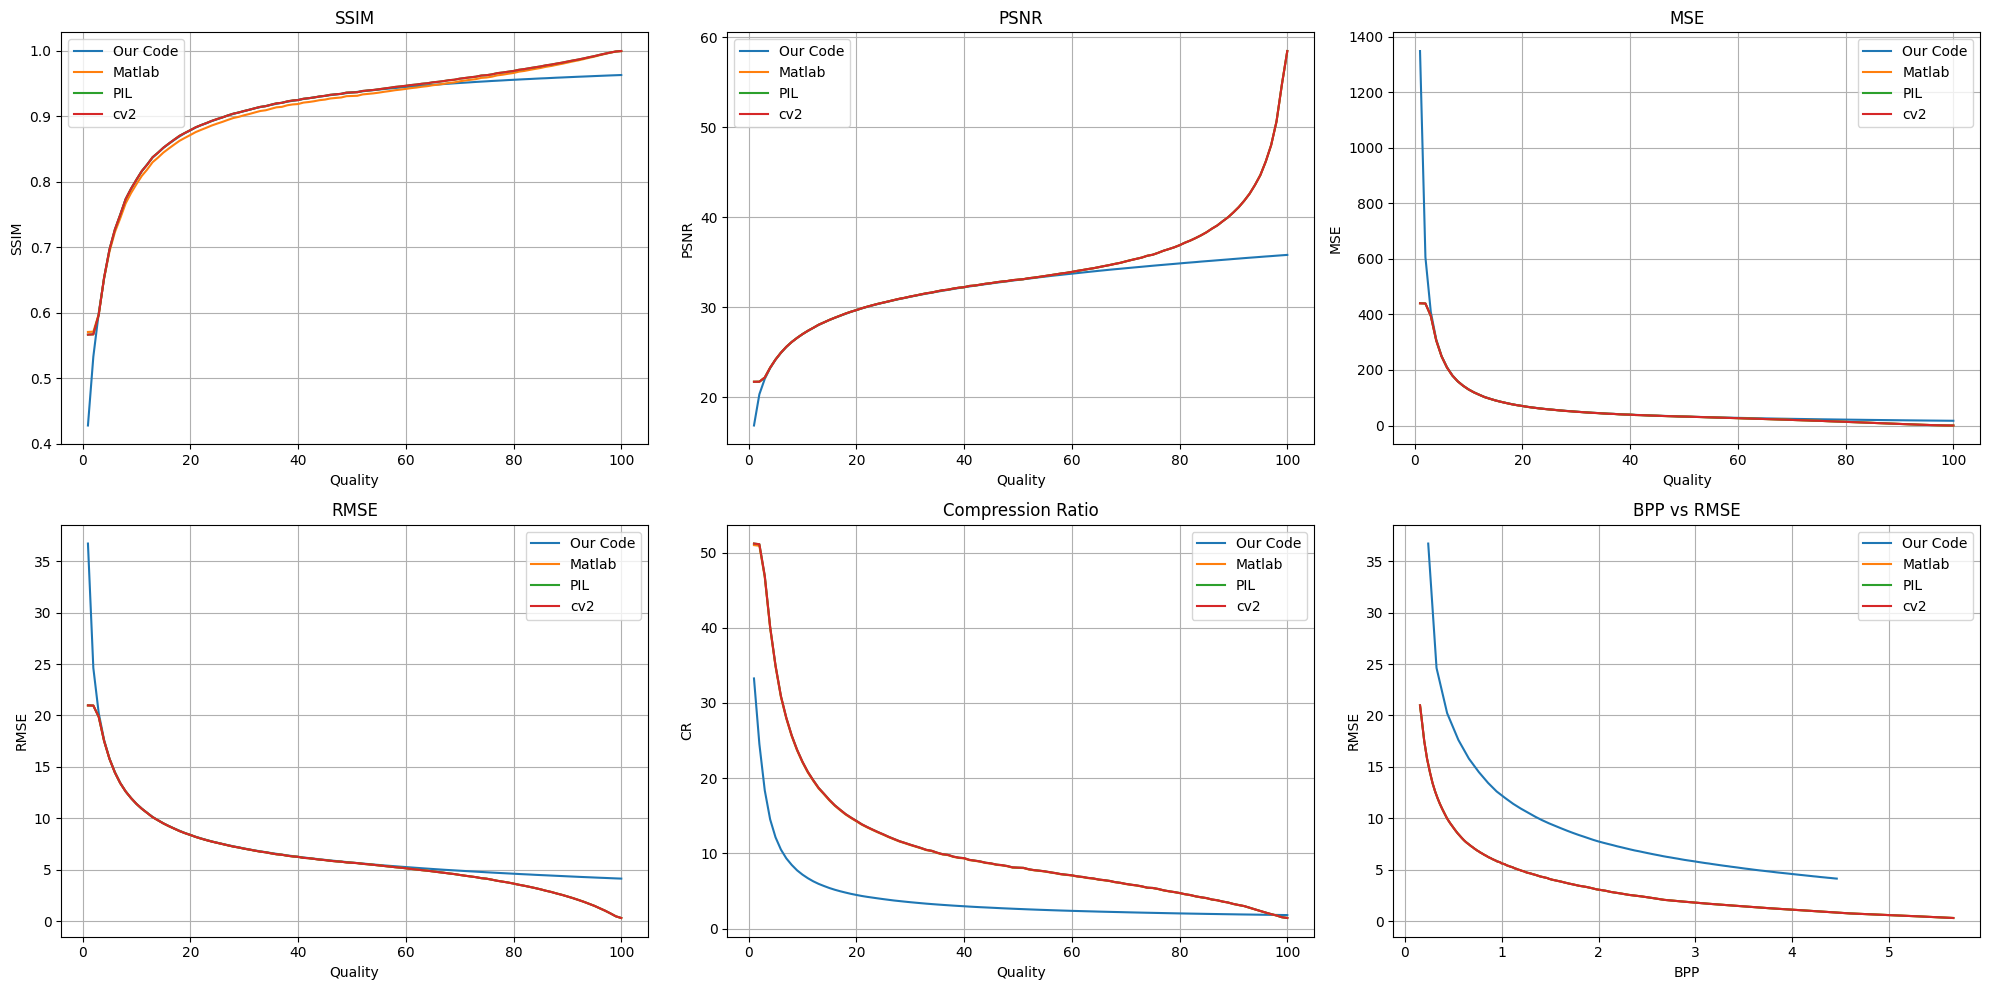

In [92]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

ax[0, 0].plot(Q, SSIM, label='Our Code')
ax[0, 0].plot(df_matlab['Quality'], df_matlab['SSIM'], label='Matlab')
ax[0, 0].plot(df_PIL['Quality'], df_PIL['SSIM'], label='PIL')
ax[0, 0].plot(df_cv2['Quality'], df_cv2['SSIM'], label='cv2')
ax[0, 0].set_title('SSIM')
ax[0, 0].legend()
ax[0, 0].set_xlabel('Quality')
ax[0, 0].set_ylabel('SSIM') 
ax[0, 0].grid(True)

ax[0, 1].plot(Q, PSNR, label='Our Code')
ax[0, 1].plot(df_matlab['Quality'], df_matlab['PSNR'], label='Matlab')
ax[0, 1].plot(df_PIL['Quality'], df_PIL['PSNR'], label='PIL')
ax[0, 1].plot(df_cv2['Quality'], df_cv2['PSNR'], label='cv2')
ax[0, 1].set_title('PSNR')
ax[0, 1].legend()
ax[0, 1].set_xlabel('Quality')
ax[0, 1].set_ylabel('PSNR')
ax[0, 1].grid(True)

ax[0, 2].plot(Q, MSE, label='Our Code')
ax[0, 2].plot(df_matlab['Quality'], df_matlab['MSE'], label='Matlab')
ax[0, 2].plot(df_PIL['Quality'], df_PIL['MSE'], label='PIL')
ax[0, 2].plot(df_cv2['Quality'], df_cv2['MSE'], label='cv2')
ax[0, 2].set_title('MSE')
ax[0, 2].legend()
ax[0, 2].set_xlabel('Quality')
ax[0, 2].set_ylabel('MSE')
ax[0, 2].grid(True)

ax[1, 0].plot(Q, RMSE, label='Our Code')
ax[1, 0].plot(df_matlab['Quality'], df_matlab['RMSE'], label='Matlab')
ax[1, 0].plot(df_PIL['Quality'], df_PIL['RMSE'], label='PIL')
ax[1, 0].plot(df_cv2['Quality'], df_cv2['RMSE'], label='cv2')
ax[1, 0].set_title('RMSE')
ax[1, 0].legend()
ax[1, 0].set_xlabel('Quality')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].grid(True)

ax[1, 1].plot(Q, CR, label='Our Code')
ax[1, 1].plot(df_matlab['Quality'], df_matlab['CompressionRatio'], label='Matlab')
ax[1, 1].plot(df_PIL['Quality'], df_PIL['Compression Ratio'], label='PIL')
ax[1, 1].plot(df_cv2['Quality'], df_cv2['Compression Ratio'], label='cv2')
ax[1, 1].set_title('Compression Ratio')
ax[1, 1].legend()
ax[1, 1].set_xlabel('Quality')
ax[1, 1].set_ylabel('CR')
ax[1, 1].grid(True)

ax[1, 2].plot(BPP, RMSE, label='Our Code')
ax[1, 2].plot(df_matlab['BPP'], df_matlab['RMSE'], label='Matlab')
ax[1, 2].plot(df_PIL['Bits Per Pixel'], df_PIL['RMSE'], label='PIL')
ax[1, 2].plot(df_cv2['Bits Per Pixel'], df_cv2['RMSE'], label='cv2')
ax[1, 2].set_title('BPP vs RMSE')
ax[1, 2].legend()
ax[1, 2].set_xlabel('BPP')
ax[1, 2].set_ylabel('RMSE')
ax[1, 2].grid(True)

plt.tight_layout()
plt.show()


<hr>
<hr>

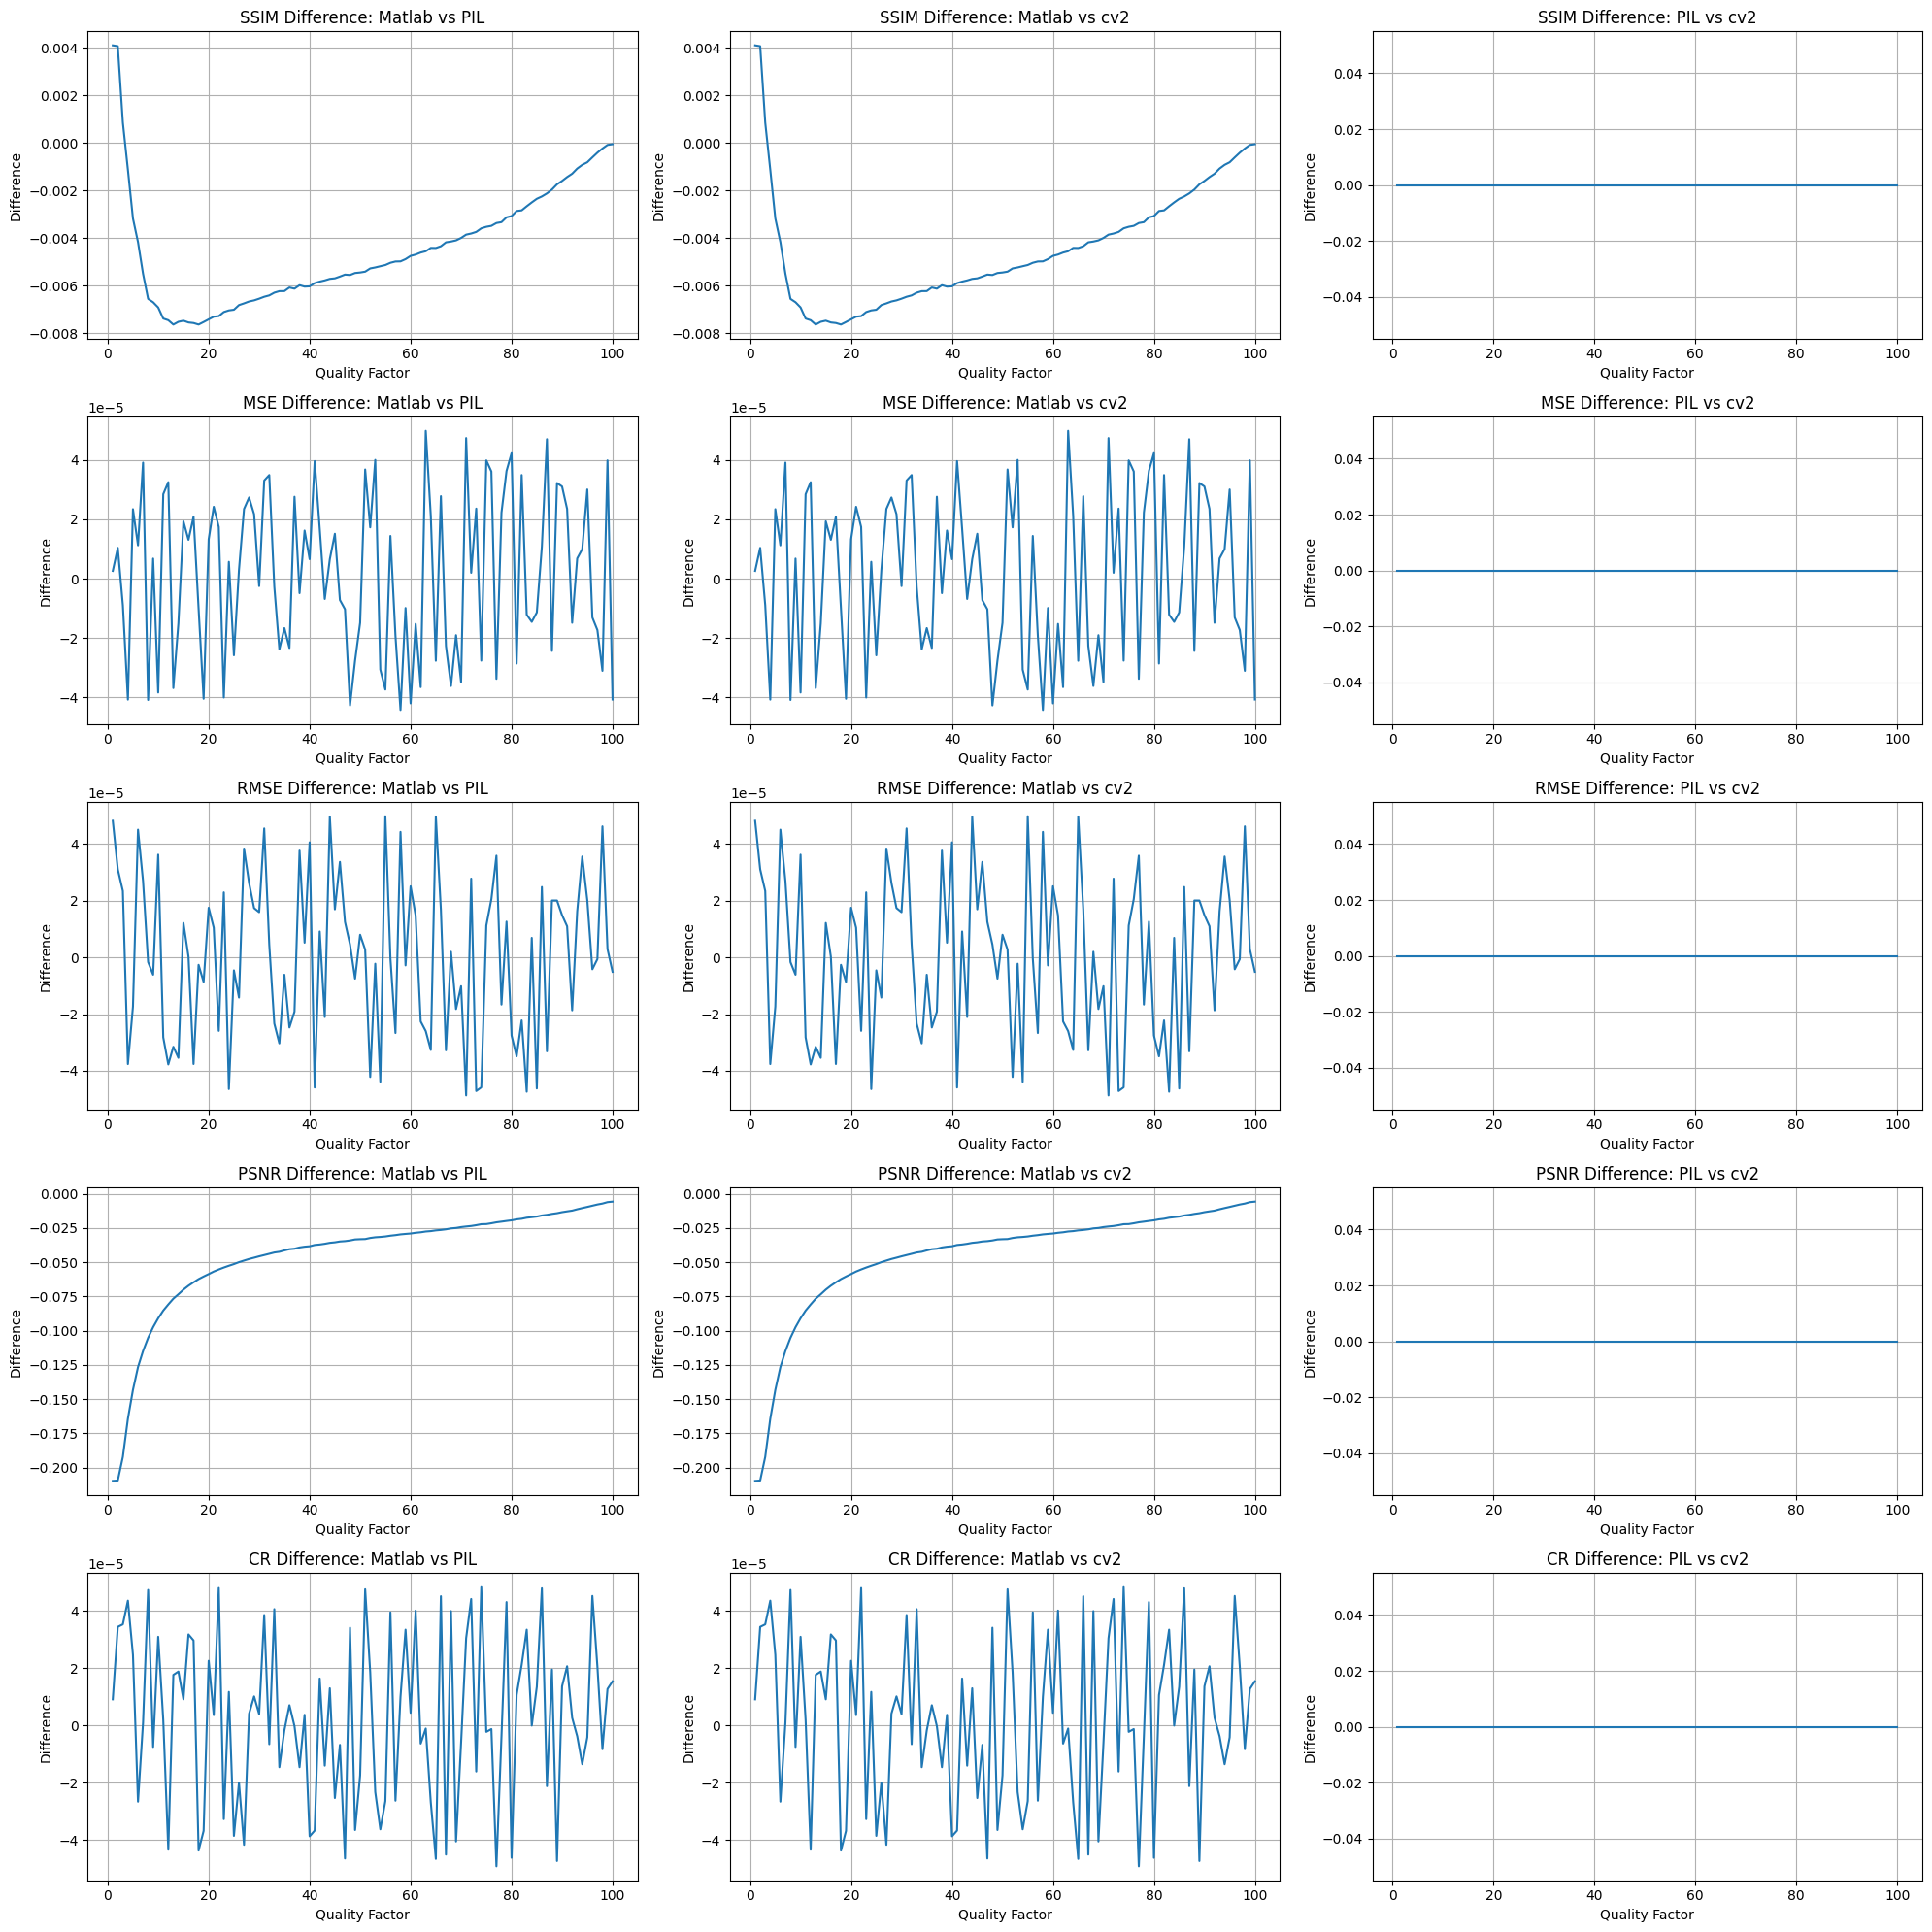

In [94]:
# Difference analysis

fig, ax = plt.subplots(5, 3, figsize=(20, 20))

ax[0, 0].plot(Q, (np.array(df_matlab['SSIM']) - np.array(df_PIL['SSIM'])))
ax[0, 0].set_title('SSIM Difference: Matlab vs PIL')
ax[0, 0].set_xlabel('Quality Factor')
ax[0, 0].set_ylabel('Difference')
ax[0, 0].grid(True)

ax[0, 1].plot(Q, (np.array(df_matlab['SSIM']) - np.array(df_cv2['SSIM'])))
ax[0, 1].set_title('SSIM Difference: Matlab vs cv2')
ax[0, 1].set_xlabel('Quality Factor')
ax[0, 1].set_ylabel('Difference')
ax[0, 1].grid(True)

ax[0, 2].plot(Q, (np.array(df_PIL['SSIM']) - np.array(df_cv2['SSIM'])))
ax[0, 2].set_title('SSIM Difference: PIL vs cv2')
ax[0, 2].set_xlabel('Quality Factor')
ax[0, 2].set_ylabel('Difference')
ax[0, 2].grid(True)

ax[1, 0].plot(Q, (np.array(df_matlab['MSE']) - np.array(df_PIL['MSE'])))
ax[1, 0].set_title('MSE Difference: Matlab vs PIL')
ax[1, 0].set_xlabel('Quality Factor')
ax[1, 0].set_ylabel('Difference')
ax[1, 0].grid(True)

ax[1, 1].plot(Q, (np.array(df_matlab['MSE']) - np.array(df_cv2['MSE'])))
ax[1, 1].set_title('MSE Difference: Matlab vs cv2')
ax[1, 1].set_xlabel('Quality Factor')
ax[1, 1].set_ylabel('Difference')
ax[1, 1].grid(True)

ax[1, 2].plot(Q, (np.array(df_PIL['MSE']) - np.array(df_cv2['MSE'])))
ax[1, 2].set_title('MSE Difference: PIL vs cv2')
ax[1, 2].set_xlabel('Quality Factor')
ax[1, 2].set_ylabel('Difference')
ax[1, 2].grid(True)

ax[2, 0].plot(Q, (np.array(df_matlab['RMSE']) - np.array(df_PIL['RMSE'])))
ax[2, 0].set_title('RMSE Difference: Matlab vs PIL')
ax[2, 0].set_xlabel('Quality Factor')
ax[2, 0].set_ylabel('Difference')
ax[2, 0].grid(True)

ax[2, 1].plot(Q, (np.array(df_matlab['RMSE']) - np.array(df_cv2['RMSE'])))
ax[2, 1].set_title('RMSE Difference: Matlab vs cv2')
ax[2, 1].set_xlabel('Quality Factor')
ax[2, 1].set_ylabel('Difference')
ax[2, 1].grid(True)

ax[2, 2].plot(Q, (np.array(df_PIL['RMSE']) - np.array(df_cv2['RMSE'])))
ax[2, 2].set_title('RMSE Difference: PIL vs cv2')
ax[2, 2].set_xlabel('Quality Factor')
ax[2, 2].set_ylabel('Difference')
ax[2, 2].grid(True)

ax[3, 0].plot(Q, (np.array(df_matlab['CompressionRatio']) - np.array(df_PIL['Compression Ratio'])))
ax[3, 0].set_title('PSNR Difference: Matlab vs PIL')
ax[3, 0].set_xlabel('Quality Factor')
ax[3, 0].set_ylabel('Difference')
ax[3, 0].grid(True)

ax[3, 1].plot(Q, (np.array(df_matlab['CompressionRatio']) - np.array(df_cv2['Compression Ratio'])))
ax[3, 1].set_title('PSNR Difference: Matlab vs cv2')
ax[3, 1].set_xlabel('Quality Factor')
ax[3, 1].set_ylabel('Difference')
ax[3, 1].grid(True)

ax[3, 2].plot(Q, (np.array(df_PIL['Compression Ratio']) - np.array(df_cv2['Compression Ratio'])))
ax[3, 2].set_title('PSNR Difference: PIL vs cv2')
ax[3, 2].set_xlabel('Quality Factor')
ax[3, 2].set_ylabel('Difference')
ax[3, 2].grid(True)

ax[4, 0].plot(Q, (np.array(df_matlab['BPP']) - np.array(df_PIL['Bits Per Pixel'])))
ax[4, 0].set_title('CR Difference: Matlab vs PIL')
ax[4, 0].set_xlabel('Quality Factor')
ax[4, 0].set_ylabel('Difference')
ax[4, 0].grid(True)

ax[4, 1].plot(Q, (np.array(df_matlab['BPP']) - np.array(df_cv2['Bits Per Pixel'])))
ax[4, 1].set_title('CR Difference: Matlab vs cv2')
ax[4, 1].set_xlabel('Quality Factor')
ax[4, 1].set_ylabel('Difference')
ax[4, 1].grid(True)

ax[4, 2].plot(Q, (np.array(df_PIL['Bits Per Pixel']) - np.array(df_cv2['Bits Per Pixel'])))
ax[4, 2].set_title('CR Difference: PIL vs cv2')
ax[4, 2].set_xlabel('Quality Factor')
ax[4, 2].set_ylabel('Difference')
ax[4, 2].grid(True)

plt.tight_layout()
plt.show()

<hr>
<hr>

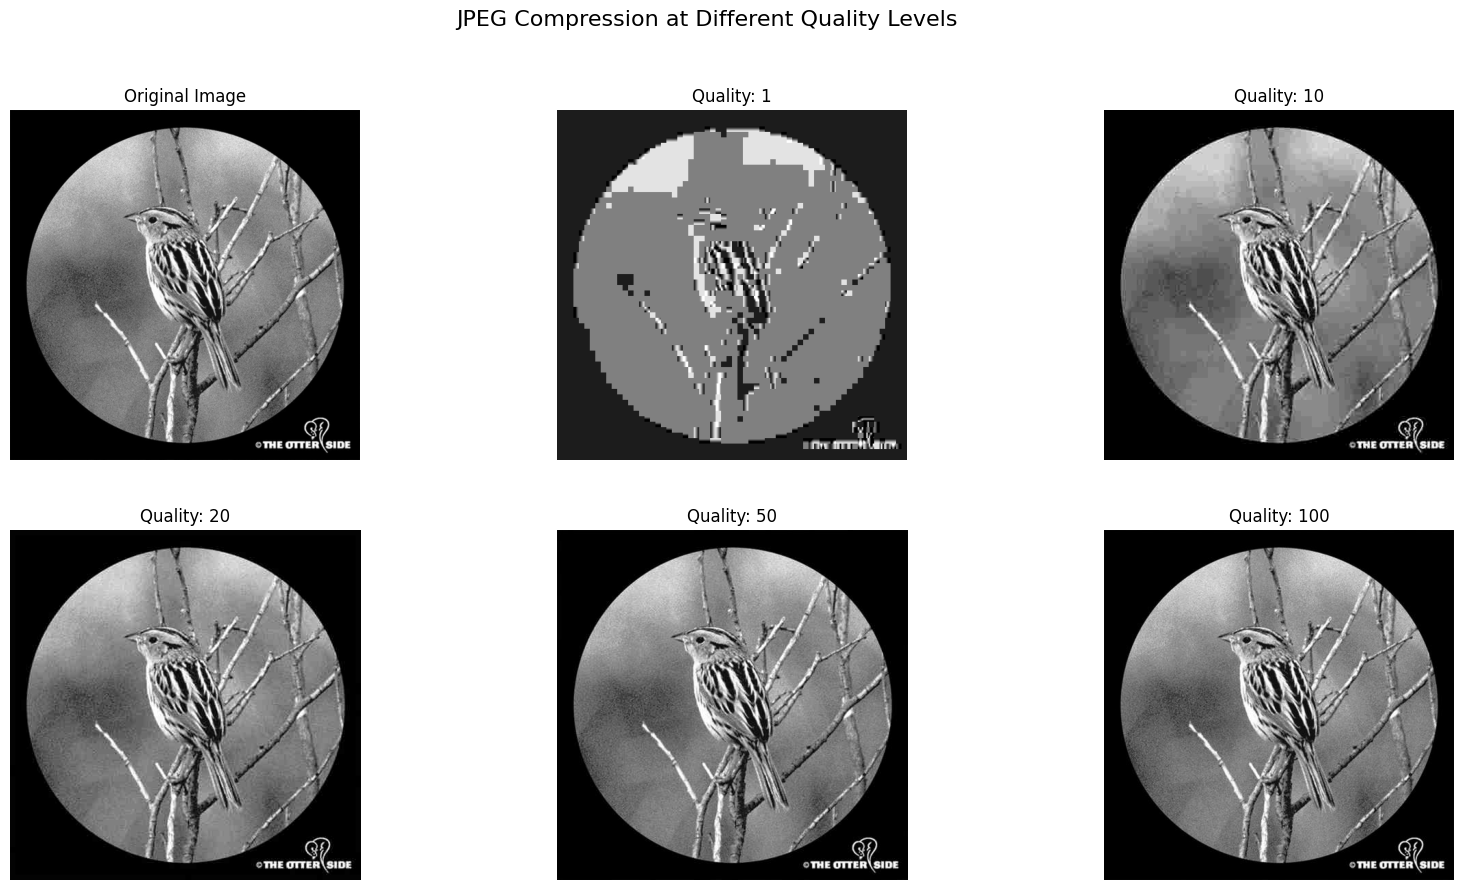

In [ ]:
filename = 'C1499.bmp'
folder = 'caltech_greyscale/'

Q = [1, 10, 20, 50, 100]

compressed_images = []
original_image = plt.imread(folder + filename)  

for q in Q:
    jpeg = JPEG(filename, folder, q)
    jpeg.compress()
    compressed_images.append(jpeg.compressed_image)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

fig.suptitle('JPEG Compression at Different Quality Levels', fontsize=16)

ax[0, 0].imshow(original_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

for i in range(1, 6):
    ax[i//3, i%3].imshow(compressed_images[i-1], cmap='gray')
    ax[i//3, i%3].set_title(f'Quality: {Q[i-1]}')
    ax[i//3, i%3].axis('off')

<hr>
<hr>

Metrics for 20 images

<hr>
<hr>

In [ ]:
image_path = 'caltech_greyscale/'
images = ['C0001.bmp', 'C0002.bmp', 'C0003.bmp', 'C0004.bmp', 'C0005.bmp',
          'C0006.bmp', 'C0007.bmp', 'C0008.bmp', 'C0009.bmp', 'C0010.bmp',
          'C0011.bmp', 'C0012.bmp', 'C0013.bmp', 'C0014.bmp', 'C0015.bmp',
          'C0016.bmp', 'C0017.bmp', 'C0018.bmp', 'C0019.bmp', 'C0020.bmp']

matlab_path = 'metrics_matlab/'

Quality = np.linspace(1, 100, 100, dtype=int)

RMSE = []
BPP = []

RMSE_matlab = []
BPP_matlab = []

for i in range(1, 21):
    filename = images[i-1]
    df_matlab = pd.read_csv(matlab_path + 'metrics_' + str(i) + '.txt', sep='\t')
    RMSE_matlab.append(df_matlab['RMSE'].values)
    BPP_matlab.append(df_matlab['BPP'].values)
    print('MATLAB file read:', filename)

MATLAB file read: C0001.bmp
MATLAB file read: C0002.bmp
MATLAB file read: C0003.bmp
MATLAB file read: C0004.bmp
MATLAB file read: C0005.bmp
MATLAB file read: C0006.bmp
MATLAB file read: C0007.bmp
MATLAB file read: C0008.bmp
MATLAB file read: C0009.bmp
MATLAB file read: C0010.bmp
MATLAB file read: C0011.bmp
MATLAB file read: C0012.bmp
MATLAB file read: C0013.bmp
MATLAB file read: C0014.bmp
MATLAB file read: C0015.bmp
MATLAB file read: C0016.bmp
MATLAB file read: C0017.bmp
MATLAB file read: C0018.bmp
MATLAB file read: C0019.bmp
MATLAB file read: C0020.bmp


In [ ]:
path = 'outputs_pil_metrics/outputs_pil/outputs_pil_'

RMSE_PIL = []
BPP_PIL = []

for i in range(1, 21):
    padded = str(i).zfill(2)
    df = pd.read_csv(path + padded + '/metrics.csv')
    RMSE_PIL.append(df['RMSE'].values)
    BPP_PIL.append(df['Bits Per Pixel'].values)
    print('PIL file read:', padded)

PIL file read: 01
PIL file read: 02
PIL file read: 03
PIL file read: 04
PIL file read: 05
PIL file read: 06
PIL file read: 07
PIL file read: 08
PIL file read: 09
PIL file read: 10
PIL file read: 11
PIL file read: 12
PIL file read: 13
PIL file read: 14
PIL file read: 15
PIL file read: 16
PIL file read: 17
PIL file read: 18
PIL file read: 19
PIL file read: 20


In [ ]:
path = 'outputs_cv2_metrics/outputs_cv2/outputs_cv2_'

RMSE_cv2 = []
BPP_cv2 = []

for i in range(1, 21):
    padded = str(i).zfill(2)
    df = pd.read_csv(path + padded + '/metrics.csv')
    RMSE_cv2.append(df['RMSE'].values)
    BPP_cv2.append(df['Bits Per Pixel'].values)
    print('cv2 file read:', padded)

cv2 file read: 01
cv2 file read: 02
cv2 file read: 03
cv2 file read: 04
cv2 file read: 05
cv2 file read: 06
cv2 file read: 07
cv2 file read: 08
cv2 file read: 09
cv2 file read: 10
cv2 file read: 11
cv2 file read: 12
cv2 file read: 13
cv2 file read: 14
cv2 file read: 15
cv2 file read: 16
cv2 file read: 17
cv2 file read: 18
cv2 file read: 19
cv2 file read: 20


In [ ]:
RMSE = []
BPP = []

name = 'C00'

for i in range(1, 21):
    padded = str(i).zfill(2)
    filename = name + padded + '.csv'
    df = pd.read_csv('metrics/' + filename)
    RMSE.append(df['RMSE'].values)
    BPP.append(df['BPP'].values)
    print('Python file read:', filename)

Python file read: C0001.csv
Python file read: C0002.csv
Python file read: C0003.csv
Python file read: C0004.csv
Python file read: C0005.csv
Python file read: C0006.csv
Python file read: C0007.csv
Python file read: C0008.csv
Python file read: C0009.csv
Python file read: C0010.csv
Python file read: C0011.csv
Python file read: C0012.csv
Python file read: C0013.csv
Python file read: C0014.csv
Python file read: C0015.csv
Python file read: C0016.csv
Python file read: C0017.csv
Python file read: C0018.csv
Python file read: C0019.csv
Python file read: C0020.csv


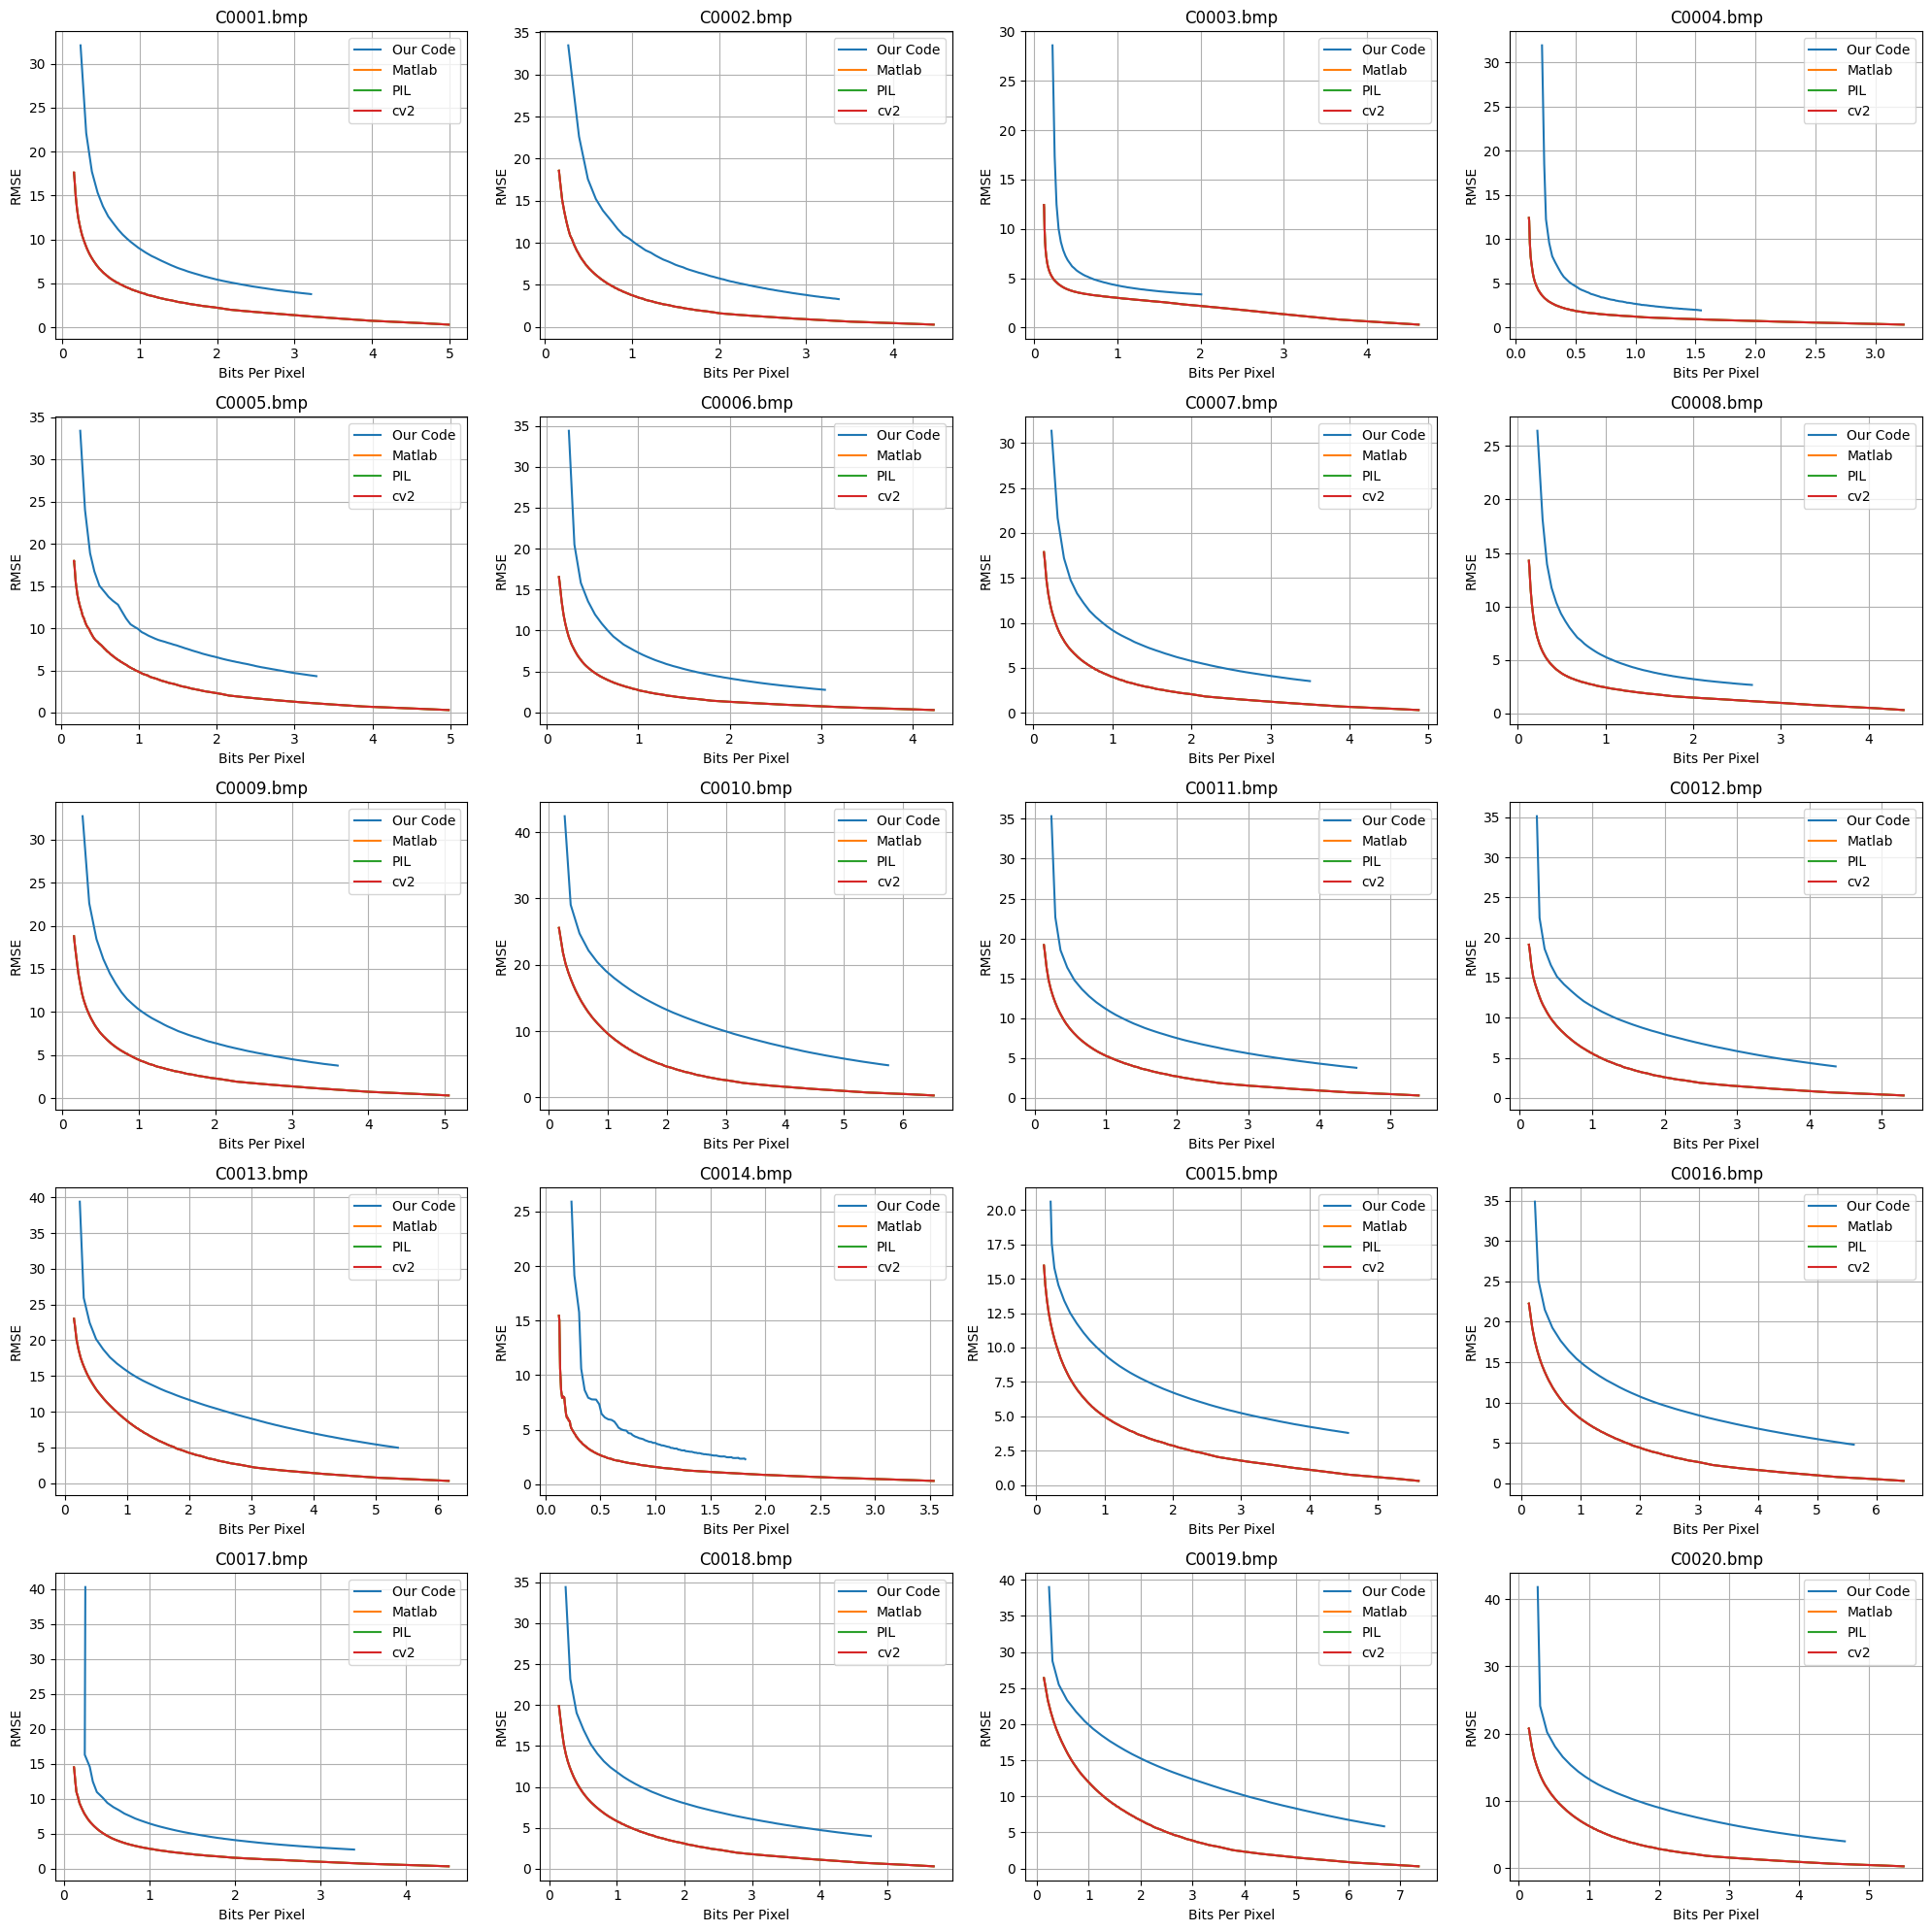

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))

for i in range(20):
    row = i // 4
    col = i % 4
    ax[row, col].plot(BPP[i], RMSE[i], label='Our Code')
    ax[row, col].plot(BPP_matlab[i], RMSE_matlab[i], label='Matlab')
    ax[row, col].plot(BPP_PIL[i], RMSE_PIL[i], label='PIL')
    ax[row, col].plot(BPP_cv2[i], RMSE_cv2[i], label='cv2')
    ax[row, col].set_title(images[i])
    ax[row, col].set_xlabel('Bits Per Pixel')
    ax[row, col].set_ylabel('RMSE')
    ax[row, col].grid(True)
    ax[row, col].legend()

plt.tight_layout()
plt.show()